# Homework 3

This Notebook builds on the unit commitment model introduced in [Notebook 5](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks) and the storage model introduced in [Notebook 2](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks).

First, load (or install if necessary) a set of packages you'll need for this assignment...

In [1]:
# Uncomment and run this first line if you need to install or update packages
#import Pkg; Pkg.add("JuMP"); Pkg.add("HiGHS"); Pkg.add("DataFrames"); Pkg.add("CSV"); Pkg.add("Plots"); Pkg.add("VegaLite")
using JuMP
using HiGHS
using DataFrames
using CSV
using Plots; plotly();
using VegaLite  # to make some nice plots

#=
Function to convert JuMP outputs (technically, AxisArrays) with two-indexes to a dataframe
Inputs:
    var -- JuMP AxisArray (e.g., value.(GEN))
Reference: https://jump.dev/JuMP.jl/v0.19/containers/
=#
function value_to_df_2dim(var)
    solution = DataFrame(var.data, :auto)
    ax1 = var.axes[1]
    ax2 = var.axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    return solution
end

value_to_df_2dim (generic function with 1 method)

## Question 1 - Compare startup costs in unit commitment

**A. Code and run basic model.**

Data for this problem is stored in [`Homeworks/hw3_data`](hw3_data/).

Following the `unit_commitment_simple` modeling formulation in [Notebook 5](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks), load the above data and create a unit commitment solver function with the following set of constraints:

- Demand balance
- Minimum / maximum generator constraints (non-committed)
- Minimum / maximum generator constraints (committed)
- Three-variable commitment formulation

Note: the data (with hours 1-24) is already in local time. Hence, do not convert from GMT to GMT-8.

Run the UC for the given day and plot a stacked area chart of generation using `@vlplot` from the `VegaLite` package.

Throughout this assignment, please use a relative MIP gap of 1% for all questions. (If you are having difficulty getting this to solve on your computer in a reasonble amount of time, you can relax the gap but please then specify clearly in your comments that you have done so.)

In [2]:
datadir = joinpath("hw3_data") 
gen_info = CSV.read(joinpath(datadir,"Generators_data.csv"), DataFrame);
fuels = CSV.read(joinpath(datadir,"Fuels_data.csv"), DataFrame);
loads = CSV.read(joinpath(datadir,"Demand.csv"), DataFrame);
gen_variable = CSV.read(joinpath(datadir,"Generators_variability.csv"), DataFrame);

# Rename all columns to lowercase (by convention)
for f in [gen_info, fuels, loads, gen_variable]
    rename!(f,lowercase.(names(f)))
end

In [7]:
# Keep columns relevant to our UC model 
select!(gen_info, 1:26) # columns 1:26
gen_df = outerjoin(gen_info,  fuels, on = :fuel) # load in fuel costs and add to data frame
rename!(gen_df, :cost_per_mmbtu => :fuel_cost)   # rename column for fuel cost
gen_df.fuel_cost[ismissing.(gen_df[:,:fuel_cost])] .= 0

# create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar):
gen_df[!, :is_variable] .= false
gen_df[in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]).(gen_df.resource),
    :is_variable] .= true;

# create full name of generator (including geographic location and cluster number)
#  for use with variable generation dataframe
gen_df.gen_full = lowercase.(gen_df.region .* "_" .* gen_df.resource .* "_" .* string.(gen_df.cluster) .* ".0");

# remove generators with no capacity (e.g. new build options that we'd use if this was capacity expansion problem)
gen_df = gen_df[gen_df.existing_cap_mw .> 0,:];

In [10]:
# 2. Convert from "wide" to "long" format
gen_variable_long = stack(gen_variable, 
                        Not(:hour), 
                        variable_name=:gen_full,
                        value_name=:cf);
# Now we have a "long" dataframe

In [8]:
function unit_commitment_simple(gen_df, loads, gen_variable, mip_gap)
    unit_commitment = Model(HiGHS.Optimizer)
    set_optimizer_attribute(unit_commitment, "mip_rel_gap", mip_gap)
    
        # Thermal resources for which unit commitment constraints apply
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id] 
        # Non-thermal resources for which unit commitment constraints do NOT apply 
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
        # Variable renewable resources
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id]
        # Non-variable (dispatchable) resources
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
        # Non-variable and non-thermal resources
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
        # Set of all generators (above are all subsets of this)
    G = gen_df.r_id
        # All time periods (hours) over which we are optimizing
    T = loads.hour
        # A subset of time periods that excludes the last time period
    T_red = loads.hour[1:end-1]  # reduced time periods without last one

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(unit_commitment, begin
            # Continuous decision variables
        GEN[G, T]  >= 0     # generation
            # Bin = binary variables; 
            # the following are all binary decisions that 
            # can ONLY take the values 0 or 1
            # The presence of these discrete decisions makes this an MILP
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)
        START[G_thermal, T], Bin  # startup decision
        SHUT[G_thermal, T], Bin   # shutdown decision
    end)
                
    # Objective function
        # Sum of variable costs + start-up costs for all generators and time periods
    @objective(unit_commitment, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)  + 
        sum(gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
                        for i in G_thermal for t in T)
    )
    
    # Demand balance constraint (supply must = demand in all time periods)
    @constraint(unit_commitment, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints 
      # 1. thermal generators requiring commitment
    @constraint(unit_commitment, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(unit_commitment, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

      # 2. non-variable generation not requiring commitment
    @constraint(unit_commitment, Cap_nt_nonvar[i in G_nt_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])
    
      # 3. variable generation, accounting for hourly capacity factor
    @constraint(unit_commitment, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Unit commitment constraints
      # 1. Minimum up time
    @constraint(unit_commitment, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

      # 2. Minimum down time
    @constraint(unit_commitment, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
 
      # 3. Commitment state
    @constraint(unit_commitment, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # Solve statement (! indicates runs in place)
    optimize!(unit_commitment)

    # Generation solution and convert to data frame 
    # with our helper function defined above
    gen = value_to_df_2dim(value.(GEN))

    # Commitment status solution and convert to data frame
    commit = value_to_df_2dim(value.(COMMIT))

    # Calculate curtailment = available wind and/or solar output that 
    # had to be wasted due to operating constraints
    curtail = innerjoin(gen_var_cf, gen, on = [:r_id, :hour])
    curtail.curt = curtail.cf .* curtail.existing_cap_mw - curtail.gen
    
    # Return the solution parameters and objective
    return (
        gen,
        commit,
        curtail,
        cost = objective_value(unit_commitment),
        status = termination_status(unit_commitment)
    )

end

unit_commitment_simple (generic function with 1 method)

In [14]:
# A spring day
#n=100
T_period = 1:24

# High solar case: 3,500 MW
#gen_df_sens = copy(gen_df)
#gen_df_sens[gen_df_sens.resource .== "solar_photovoltaic",
 #   :existing_cap_mw] .= 3500

loads_multi = loads[in.(loads.hour,Ref(T_period)),:]
gen_variable_multi = gen_variable_long[in.(gen_variable_long.hour,Ref(T_period)),:]

# Note we reduce the MIP gap tolerance threshold here to increase tractability
# Here we set it to a 1% gap (mip_gap=0.01), meaning that we will terminate once we have 
# a feasible integer solution guaranteed to be within 1% of the objective
# function value of the optimal solution (e.g. the upper and lower bound are within 1% of
# each other as HiGHS traverses the branch and bound tree).
# HiGHS's default MIP gap is 0.0001 (0.01%), which can take a longer time for 
# any complex problem. So it is important to set this to a realistic value.
# For a list of all solver options implemented via HiGHS.jl see 
# https://github.com/jump-dev/HiGHS.jl
solution = unit_commitment_simple(
    gen_df_sens, loads_multi, gen_variable_multi, 0.01); #1% MIP Gap

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2013 rows, 1707 cols, 6595 nonzeros
1791 rows, 1423 cols, 7349 nonzeros

Solving MIP model with:
   1791 rows
   1423 cols (968 binary, 0 integer, 0 implied int., 455 continuous)
   7349 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   473023.409268   inf                  inf        0      0     14       505     0.1s
 R       0       0         0   0.00%   473144.350903   473965.776921      0.17%      107     13     28       532     0.1s

Solving report
  Status            Optimal
  Primal bound      473965.776921
  Dual bound        473144.

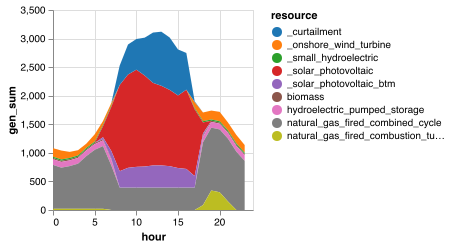

In [12]:
# Add in BTM solar and curtailment and plot results

sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :curt => sum)
curtail[!, :resource] .= "_curtailment"
rename!(curtail, :curt_sum => :gen_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :gen_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

**B. Zero startup costs sensitivity**

Next, create a modified version of the generator dataframe (`gen_df_sens = copy(gen_df)`) and set the startup costs for all generators to be 0.

Rerun the UC and compare with the first solution. What are the main differences and why?

In [18]:
gen_df_sens = copy(gen_df)

Row,r_id,resource,region,existing_cap_mw,num_units,cap_size,var_om_cost_per_mwh,var_om_cost_per_mwh_in,fuel,heat_rate_mmbtu_per_mwh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,min_power,ramp_up_percentage,ramp_dn_percentage,start_cost_per_mw,start_fuel_mmbtu_per_mw,up_time,down_time,self_disch,eff_up,eff_down,ratio_power_to_energy,min_duration,max_duration,cluster,fuel_cost,co2_content_tons_per_mmbtu,is_variable,gen_full
,Int64?,String?,String15?,Float64?,Int64?,Float64?,Float64?,Int64?,String31,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64?,Float64?,Int64?,Int64?,Int64?,Float64?,Float64?,Float64?,Int64?,Int64?,Int64?,Float64?,Float64?,Bool,String
1,1,biomass,WEC_SDGE,21.4,20,1.07,5.234,0,None,12.76,1.471,4.147,0.71,1.0,1.0,0,0.0,0,0,0,1.0,1.0,1.0,0,0,1,0.0,0.0,false,wec_sdge_biomass_1.0
2,2,hydroelectric_pumped_storage,WEC_SDGE,100.0,2,21.0,0.0,0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0,0,0,0.866,0.866,0.25,0,0,1,0.0,0.0,false,wec_sdge_hydroelectric_pumped_storage_1.0
3,3,natural_gas_fired_combined_cycle,WEC_SDGE,600.0,1,607.1,3.4,0,pacific_naturalgas,7.52,0.0,0.0,0.362,0.4,0.4,87,2.0,6,6,0,1.0,1.0,1.0,0,0,1,2.57,0.05306,false,wec_sdge_natural_gas_fired_combined_cycle_1.0
4,4,natural_gas_fired_combined_cycle,WEC_SDGE,500.0,1,570.0,3.4,0,pacific_naturalgas,7.15,0.0,0.0,0.351,0.4,0.4,87,2.0,6,6,0,1.0,1.0,1.0,0,0,2,2.57,0.05306,false,wec_sdge_natural_gas_fired_combined_cycle_2.0
5,5,natural_gas_fired_combined_cycle,WEC_SDGE,336.0,3,112.0,10.8,0,pacific_naturalgas,10.03,0.0,0.0,0.446,3.78,3.78,113,3.5,6,6,0,1.0,1.0,1.0,0,0,3,2.57,0.05306,false,wec_sdge_natural_gas_fired_combined_cycle_3.0
6,6,natural_gas_fired_combustion_turbine,WEC_SDGE,91.6,2,45.8,10.8,0,pacific_naturalgas,10.69,0.0,0.0,0.8,3.78,3.78,113,3.5,1,1,0,1.0,1.0,1.0,0,0,1,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_1.0
7,7,natural_gas_fired_combustion_turbine,WEC_SDGE,49.9,1,49.9,10.8,0,pacific_naturalgas,10.48,0.0,0.0,0.487,3.78,3.78,113,3.5,1,1,0,1.0,1.0,1.0,0,0,2,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_2.0
8,8,natural_gas_fired_combustion_turbine,WEC_SDGE,48.1,1,48.1,10.8,0,pacific_naturalgas,11.04,0.0,0.0,0.437,3.78,3.78,113,3.5,1,1,0,1.0,1.0,1.0,0,0,3,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_3.0
9,9,natural_gas_fired_combustion_turbine,WEC_SDGE,34.6,1,34.6,10.8,0,pacific_naturalgas,16.86,0.0,0.0,0.954,3.78,3.78,113,3.5,1,1,0,1.0,1.0,1.0,0,0,4,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_4.0


In [45]:
#i = gen_df.r_id

sizei = size(gen_df_sens.r_id)[1]

for i in [gen_df_sens.r_id]
    gen_df_sens[gen_df_sens.r_id .==i, :start_cost_per_mw] .= 0
    #gen_df_sens[gen_df_sens.r_id.==i,
    #:start_cost_per_mw] .= 0
end

In [46]:
gen_df_sens

Row,r_id,resource,region,existing_cap_mw,num_units,cap_size,var_om_cost_per_mwh,var_om_cost_per_mwh_in,fuel,heat_rate_mmbtu_per_mwh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,min_power,ramp_up_percentage,ramp_dn_percentage,start_cost_per_mw,start_fuel_mmbtu_per_mw,up_time,down_time,self_disch,eff_up,eff_down,ratio_power_to_energy,min_duration,max_duration,cluster,fuel_cost,co2_content_tons_per_mmbtu,is_variable,gen_full
,Int64?,String?,String15?,Float64?,Int64?,Float64?,Float64?,Int64?,String31,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64?,Float64?,Int64?,Int64?,Int64?,Float64?,Float64?,Float64?,Int64?,Int64?,Int64?,Float64?,Float64?,Bool,String
1,1,biomass,WEC_SDGE,21.4,20,1.07,5.234,0,None,12.76,1.471,4.147,0.71,1.0,1.0,0,0.0,0,0,0,1.0,1.0,1.0,0,0,1,0.0,0.0,false,wec_sdge_biomass_1.0
2,2,hydroelectric_pumped_storage,WEC_SDGE,100.0,2,21.0,0.0,0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0,0,0,0.866,0.866,0.25,0,0,1,0.0,0.0,false,wec_sdge_hydroelectric_pumped_storage_1.0
3,3,natural_gas_fired_combined_cycle,WEC_SDGE,600.0,1,607.1,3.4,0,pacific_naturalgas,7.52,0.0,0.0,0.362,0.4,0.4,0,2.0,6,6,0,1.0,1.0,1.0,0,0,1,2.57,0.05306,false,wec_sdge_natural_gas_fired_combined_cycle_1.0
4,4,natural_gas_fired_combined_cycle,WEC_SDGE,500.0,1,570.0,3.4,0,pacific_naturalgas,7.15,0.0,0.0,0.351,0.4,0.4,0,2.0,6,6,0,1.0,1.0,1.0,0,0,2,2.57,0.05306,false,wec_sdge_natural_gas_fired_combined_cycle_2.0
5,5,natural_gas_fired_combined_cycle,WEC_SDGE,336.0,3,112.0,10.8,0,pacific_naturalgas,10.03,0.0,0.0,0.446,3.78,3.78,0,3.5,6,6,0,1.0,1.0,1.0,0,0,3,2.57,0.05306,false,wec_sdge_natural_gas_fired_combined_cycle_3.0
6,6,natural_gas_fired_combustion_turbine,WEC_SDGE,91.6,2,45.8,10.8,0,pacific_naturalgas,10.69,0.0,0.0,0.8,3.78,3.78,0,3.5,1,1,0,1.0,1.0,1.0,0,0,1,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_1.0
7,7,natural_gas_fired_combustion_turbine,WEC_SDGE,49.9,1,49.9,10.8,0,pacific_naturalgas,10.48,0.0,0.0,0.487,3.78,3.78,0,3.5,1,1,0,1.0,1.0,1.0,0,0,2,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_2.0
8,8,natural_gas_fired_combustion_turbine,WEC_SDGE,48.1,1,48.1,10.8,0,pacific_naturalgas,11.04,0.0,0.0,0.437,3.78,3.78,0,3.5,1,1,0,1.0,1.0,1.0,0,0,3,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_3.0
9,9,natural_gas_fired_combustion_turbine,WEC_SDGE,34.6,1,34.6,10.8,0,pacific_naturalgas,16.86,0.0,0.0,0.954,3.78,3.78,0,3.5,1,1,0,1.0,1.0,1.0,0,0,4,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_4.0


In [47]:
solution = unit_commitment_simple(
    gen_df_sens, loads_multi, gen_variable_multi, 0.01);

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2013 rows, 1707 cols, 6595 nonzeros
1791 rows, 1423 cols, 7349 nonzeros

Solving MIP model with:
   1791 rows
   1423 cols (968 binary, 0 integer, 0 implied int., 455 continuous)
   7349 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   391175.854994   inf                  inf        0      0     13       272     0.0s
 R       0       0         0   0.00%   394093.23285    396102.047135      0.51%      508     58     50       651     0.1s

Solving report
  Status            Optimal
  Primal bound      396102.047135
  Dual bound        394093.

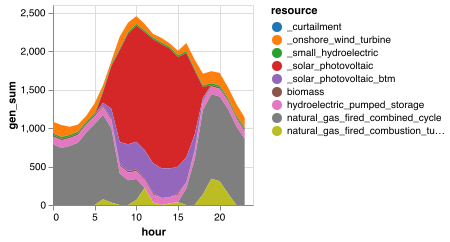

In [48]:
# Add in BTM solar and curtailment and plot results

sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :curt => sum)
curtail[!, :resource] .= "_curtailment"
rename!(curtail, :curt_sum => :gen_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :gen_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

## Question 2: Implement pumped hydropower storage

In the data, we have a generator `hydroelectric_pumped_storage` which is a pumped hydro storage (PHS) facility. We have been treating it as a free resource, but in fact, it's a battery. 

The PHS equations for stored water are identical to the state of charge for the battery in Notebook 2:

\begin{align*} 
SOC_t = SOC_{t-1} + \big(CHARGE_t * battery\_eff - \frac{DISCHARGE_t}{battery\_eff}\big)  \quad \forall t \in T
\end{align*}

In addition, the PHS has a power capacity constraint given in the dataframe's `existing_cap_mw` variable. You will also need to implement an energy capacity constraint. 

**A. Code pumped hydropower storage constraints.**

Copy the `unit_commitment_simple` code above into a new cell below and rename the function `unit_commitment_storage`.

Reviewing [Notebook 2](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks), add in relevant constraints for charging and discharging pumped hydropower. Assume the following parameters:

- One-way efficiency is $battery_{eff} = 0.84$ (i.e., round-trip efficiency = $0.7$)
- Energy capacity = 4 x Power capacity
- Stored energy starts and ends the day at 50% capacity (you will need to code these constraints)

Indicate which equations and variables you have added and explain your steps using inline code comments (e.g. `# Comment`).

In [49]:
function unit_commitment_storage(gen_df, loads, gen_variable, mip_gap)
    unit_commitment = Model(HiGHS.Optimizer)
    set_optimizer_attribute(unit_commitment, "mip_rel_gap", mip_gap)
    
        # Thermal resources for which unit commitment constraints apply
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id] 
        # Non-thermal resources for which unit commitment constraints do NOT apply 
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
        # Variable renewable resources
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id]
        # Non-variable (dispatchable) resources
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
        # Non-variable and non-thermal resources
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
        # Set of all generators (above are all subsets of this)
    G = gen_df.r_id
        # All time periods (hours) over which we are optimizing
    T = loads.hour
        # A subset of time periods that excludes the last time period
    T_red = loads.hour[1:end-1]  # reduced time periods without last one

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(unit_commitment, begin
            # Continuous decision variables
        GEN[G, T]  >= 0     # generation
            # Bin = binary variables; 
            # the following are all binary decisions that 
            # can ONLY take the values 0 or 1
            # The presence of these discrete decisions makes this an MILP
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)
        START[G_thermal, T], Bin  # startup decision
        SHUT[G_thermal, T], Bin   # shutdown decision
        SOC[T] >= 0 # state of charge
    end)
                
    # Objective function
        # Sum of variable costs + start-up costs for all generators and time periods
    @objective(unit_commitment, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)  + 
        sum(gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
                        for i in G_thermal for t in T)
    )
    
    # Demand balance constraint (supply must = demand in all time periods)
    @constraint(unit_commitment, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints 
      # 1. thermal generators requiring commitment
    @constraint(unit_commitment, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(unit_commitment, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

      # 2. non-variable generation not requiring commitment
    @constraint(unit_commitment, Cap_nt_nonvar[i in G_nt_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])
    
      # 3. variable generation, accounting for hourly capacity factor
    @constraint(unit_commitment, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Unit commitment constraints
      # 1. Minimum up time
    @constraint(unit_commitment, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

      # 2. Minimum down time
    @constraint(unit_commitment, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
 
      # 3. Commitment state
    @constraint(unit_commitment, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])


    
    ##PHS charging constraints

    battery_eff = 0.84
    energy_cap = 4*gen_df[gen_df.resource.=="hydroelectric_pumped_storage", :existing_cap_mw][1]
    start_charge = 0.5*energy_cap
    
    #@constraint(unit_commitment, cEnergyCapacity
     #   EGEN[t] <= 4*gen_df[gen_df.resource.=="hydroelectric_pumped_storage", :existing_cap_mw][1])
    # First period state of charge:
    @constraint(unit_commitment, cStateOfChargeStart,
        SOC[1] == start_charge + (CHARGE[1]*battery_eff - DISCHARGE[1]/battery_eff)
        ) 

    # All other time periods, defined recursively based on prior state of charge:
    @constraint(PV_model, cStateOfCharge[t in time_series.T[(time_series.T .> 1)]],
        SOC[t] == SOC[t-1] + (CHARGE[t]*battery_eff - DISCHARGE[t]/battery_eff)
        );

    #last period state of charge
    @constraint(PV_model, cStateOfChargeEnd,
        SOC[24] == start_charge + (CHARGE[1]*battery_eff - DISCHARGE[1]/battery_eff)
        ) 
    # Solve statement (! indicates runs in place)
    optimize!(unit_commitment)

    # Generation solution and convert to data frame 
    # with our helper function defined above
    gen = value_to_df_2dim(value.(GEN))

    # Commitment status solution and convert to data frame
    commit = value_to_df_2dim(value.(COMMIT))

    # Calculate curtailment = available wind and/or solar output that 
    # had to be wasted due to operating constraints
    curtail = innerjoin(gen_var_cf, gen, on = [:r_id, :hour])
    curtail.curt = curtail.cf .* curtail.existing_cap_mw - curtail.gen
    
    # Return the solution parameters and objective
    return (
        gen,
        commit,
        curtail,
        cost = objective_value(unit_commitment),
        status = termination_status(unit_commitment)
    )

end

unit_commitment_storage (generic function with 1 method)

In [50]:
solution = unit_commitment_simple(
    gen_df_sens, loads_multi, gen_variable_multi, 0.01);

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2013 rows, 1707 cols, 6595 nonzeros
1791 rows, 1423 cols, 7349 nonzeros

Solving MIP model with:
   1791 rows
   1423 cols (968 binary, 0 integer, 0 implied int., 455 continuous)
   7349 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   391175.854994   inf                  inf        0      0     13       272     0.1s
 R       0       0         0   0.00%   394093.23285    396102.047135      0.51%      508     58     50       651     0.1s

Solving report
  Status            Optimal
  Primal bound      396102.047135
  Dual bound        394093.

**B. Solve the new UC with PHS and plot.**

Using the above formulation, solve for the same parameters in Problem 1 and plot. For the purposes of plotting, you will want to create two resources&mdash;PHS_charge and PHS_discharge. By convention, you could put PHS_charge on top to indicate this is increasing system load.

**C. Interpret results**

Answer with a few sentences each of the following:

1. Compare your results to `unit_commitment_simple`. Have any commitments changed?

2. Interpret what is happening with the PHS facility during the day in terms of charging and discharging.

3. Has curtailment reduced? (Explain this in the context of the PHS operation.)